In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import gym
import rec_gym
from rec_gym.wrappers import StatsWrapper, FlattenObservationsWrapper
from copy import deepcopy
from rec_gym.runner import run_experiment
from agents.baselines import RandomAgent, DotProdAgent, MFAgent
from agents.dqn import Qagent
from agents.ddpg import DDPGAgent
import tensorflow as tf
# import tensorflow.contrib.eager as tfe
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
# tfe.enable_eager_execution()

def prepare_random_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    action_size = env.unwrapped.n_rec
    agent = RandomAgent(action_size = action_size)    
    return agent, wrapped, env

def prepare_ddpg_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    agent = DDPGAgent(action_size = action_size,
                     state_dim = state_dim,
                     action_dim = action_dim,
                     gamma = .9,
                     sess = sess,
                     optimizer = tf.train.AdamOptimizer(
                         learning_rate=0.01
                     ),
                     max_tf_checkpoints_to_keep = 3,
                     experience_size = 300,
                     per = True,
                     batch_size = 64, 
                     start_steps = 400)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env

def prepare_dqn_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = Qagent(sess=sess,
                     state_dim=(state_dim,),
                     action_dim=(action_dim,),
                     epsilon=0.2,
                     action_size=action_size,
                     logdir=None,
                     replay_size=1000,
                     batch_size=50)
    sess.run(tf.global_variables_initializer())
    
    return agent, wrapped, env

def prepare_dotprod_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    agent = DotProdAgent(n_rec=action_size)
    return agent, wrapped, env

def prepare_mf_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = MFAgent(n_rec=action_size, state_dim=state_dim, action_dim=action_dim, sess=sess)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env


    
    

In [5]:
# import tensorflow as tf
# tf.enable_eager_execution()


# class DRRpLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(DRRpLayer, self).__init__()

#     def build(self, input_shape):
#         hist_shape, user_shape = input_shape
#         n, k = hist_shape[1:]
#         print(n, k)
#         self.w = self.add_variable("state_repr_weights", [int(n), int(k)])

#     def call(self, hist_user):
#         H, u = hist_user

#         n = int(tf.shape(H)[1])
#         k = int(tf.shape(H)[2])

#         tiled = tf.tile(self.w * H, multiples=[1, n, 1])
#         repeated = tf.reshape(tf.tile(self.w * H, multiples=[1, 1, n]), [tf.shape(H)[0], tf.shape(H)[1] * n, -1])
#         ones = tf.ones([n, n])
#         mask_a = tf.matrix_band_part(ones, 0, -1)  # upper
#         mask_b = tf.matrix_band_part(ones, 0, 0)  # diag
#         mask = tf.cast(mask_a - mask_b, dtype=tf.int64)

#         s = tf.boolean_mask(tiled * repeated, tf.reshape(mask, [-1]), axis=1)
#         s = tf.reshape(s, shape=(tf.shape(s)[0], -1))
#         s = tf.concat([tf.reshape(H, shape=(tf.shape(H)[0], -1)), s], axis=1)
#         assert int(tf.shape(s)[-1]) == (n * (n - 1) / 2 + n) * k
#         return s


# class DRRuLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(DRRuLayer, self).__init__()

#     def build(self, input_shape):
#         print(input_shape)
#         hist_shape, user_shape = input_shape
#         n, k = hist_shape[1:]
#         print(n, k)
#         self.w = self.add_variable("state_repr_weights", [int(n), int(k)])

#     def call(self, hist_user):
#         H, u = hist_user

#         n = int(tf.shape(H)[1])
#         k = int(tf.shape(H)[2])

#         flat_hist = tf.reshape(H, shape=(tf.shape(H)[0], -1))

#         #         user_item = tf.tile(u, multiples=[1, n, 1]) * H
#         #         user_item = tf.reshape(user_item, shape=(tf.shape(user_item)[0], -1))
#         tiled = tf.tile(self.w * H, multiples=[1, n, 1])
#         repeated = tf.reshape(tf.tile(self.w * H, multiples=[1, 1, n]), [tf.shape(H)[0], tf.shape(H)[1] * n, -1])
#         ones = tf.ones([n, n])
#         mask_a = tf.matrix_band_part(ones, 0, -1)  # upper
#         mask_b = tf.matrix_band_part(ones, 0, 0)  # diag
#         mask = tf.cast(mask_a - mask_b, dtype=tf.int64)

#         s = tf.boolean_mask(tiled * repeated, tf.reshape(mask, [-1]), axis=1)
#         s = tf.reshape(s, shape=(tf.shape(s)[0], -1))

#         s = tf.concat([s, flat_hist], axis=1)

#         assert int(tf.shape(s)[-1]) == (n * (n - 1) / 2 + n) * k
#         return s


# class DRRaveLayer(tf.keras.layers.Layer):
#     def __init__(self):
#         super(DRRaveLayer, self).__init__()

#     def build(self, input_shape):
#         print(input_shape)
#         hist_shape, user_shape = input_shape
#         n, k = hist_shape[1:]
#         print(n, k)
#         self.w = self.add_variable("state_repr_weights", [int(n), int(k)])

#     def call(self, hist_user):
#         H, u = hist_user

#         n = int(tf.shape(H)[1])
#         k = int(tf.shape(H)[2])

#         avg = tf.reduce_mean(self.w * H, axis=1, keepdims=True)
#         s = tf.concat([u, u * avg, avg], axis=-1)
#         assert int(tf.shape(s)[-1]) == 3 * k
#         return s


# class Actor(tf.keras.Model):
#     def __init__(self, hidden_layers1, hidden_layers2, output_size):
#         super(Actor, self).__init__()
#         self.fc1 = tf.keras.layers.Dense(hidden_layers1, activation=tf.nn.tanh)
#         self.fc2 = tf.keras.layers.Dense(hidden_layers2, activation=tf.nn.tanh)
#         self.fc3 = tf.keras.layers.Dense(output_size, activation=tf.nn.tanh)

#     def call(self, x):
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         return x


# class Critic(tf.keras.Model):
#     def __init__(self, hidden_layer1):
#         super(Critic, self).__init__()
#         self.fc1 = tf.keras.layers.Dense(hidden_layer1, activation=tf.nn.tanh)
#         self.fc2 = tf.keras.layers.Dense(1, activation=tf.nn.tanh)

#     def call(self, state, action):
#         x = tf.concat([state, action], axis=-1)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return tf.squeeze(x)

# def reduce_std(tensor, axis=None, keepdims=False):
#     """
#     get the standard deviation of a Tensor
#     :param tensor: (TensorFlow Tensor) the input tensor
#     :param axis: (int or [int]) the axis to itterate the std over
#     :param keepdims: (bool) keep the other dimensions the same
#     :return: (TensorFlow Tensor) the std of the tensor
#     """
#     return tf.sqrt(reduce_var(tensor, axis=axis, keepdims=keepdims))


# def reduce_var(tensor, axis=None, keepdims=False):
#     """
#     get the variance of a Tensor
#     :param tensor: (TensorFlow Tensor) the input tensor
#     :param axis: (int or [int]) the axis to itterate the variance over
#     :param keepdims: (bool) keep the other dimensions the same
#     :return: (TensorFlow Tensor) the variance of the tensor
#     """
#     tensor_mean = tf.reduce_mean(tensor, axis=axis, keepdims=True)
#     devs_squared = tf.square(tensor - tensor_mean)
#     return tf.reduce_mean(devs_squared, axis=axis, keepdims=keepdims)


# from agents.utils import Agent
# import numpy as np


# class DDPGAgent(Agent):
#     def __init__(self,
#                  drp,
#                  actor,
#                  critic,
#                  target_actor,
#                  target_critic,
#                  replay,
#                  actor_lr=1e-3,
#                  critic_lr=1e-3,
#                  gamma=0.9,
#                  batch_size=25,
#                  logdir=None,
#                  ):
#         self.drp = drp
#         self.actor = actor
#         self.critic = critic

#         self.target_actor = target_actor
#         self.target_critic = target_critic

#         self.replay = replay

#         self.last_action = None
#         self.last_u = None
#         self.last_H = None
#         self.last_reward = None

#         self._train_step = 0
#         self._step = 0

#         self.gamma = gamma
#         self.actor_optimizer = tf.train.AdamOptimizer(actor_lr)
#         self.critic_optimizer = tf.train.AdamOptimizer(critic_lr)
#         self.batch_size = batch_size

#         self.global_step = tf.train.get_or_create_global_step()
#         self.logdir = logdir
#         self.writer = tf.contrib.summary.create_file_writer(logdir, flush_millis=500)
#         self.writer.set_as_default()

#     def begin_episode(self, observation):
#         return self._select_action(observation)

#     def step(self, reward, observation, info=None):
#         self.last_reward = reward
#         if len(self.replay) > self.batch_size:
#             self._train()
#         return self._select_action(observation)


#     def _select_action(self, observation):
#         u, H = observation
#         u = u[np.newaxis]

#         s = [H[np.newaxis], u[np.newaxis]]

#         state_repr = self.drp(s)
#         a = self.actor(state_repr)

#         if self.last_reward:
#             data = [self.last_u, self.last_H, self.last_action, u, H, self.last_reward, False]
#             # print(data)
#             self.replay.add(data)

#         self.last_action = tf.squeeze(a, axis=0)
#         self.last_u = u
#         self.last_H = H
#         return tf.squeeze(a)

#     def _sync_targets(self):
#         self.target_actor.set_weights(self.actor.get_weights())
#         self.target_critic.set_weights(self.critic.get_weights())

#     def _train(self):
#         self._train_step += 1
#         self.global_step.assign_add(1)
#         if (self._train_step % 100): self._sync_targets()
#         #         print(self.global_step)

#         batch = self.replay.sample(self.batch_size)
#         batch_u, batch_H, batch_a, batch_next_u, batch_next_H, batch_r, batch_done = [np.array(x)
#                                                                                       for x in
#                                                                                       zip(*[elem for elem in batch])]

#         batch_s = [batch_H, batch_u]
#         batch_snext = [batch_next_H, batch_next_u]

#         # compute gradients
#         with tf.GradientTape(persistent=True) as t:
#             batch_s_repr = self.drp(batch_s)
#             batch_snext_repr = self.drp(batch_snext)

#             with t.stop_recording():
#                 # print(batch_snext)
#                 # print(self.target_actor(batch_snext))
#                 next_q = self.target_critic(batch_snext_repr, self.target_actor(batch_snext_repr))
#                 target = batch_r + self.gamma * (1 - batch_done) * next_q

#             q = self.critic(batch_s_repr, batch_a)
#             # loss = tf.losses.mean_squared_error(target, q)
#             loss = tf.reduce_mean((target - q) ** 2)

#             a = self.actor(batch_s_repr)
#             qa = self.critic(batch_s_repr, a)
#             p_loss = -tf.reduce_mean(qa)

#         # dq_da = t.gradient(-qa, a)

#         actor_grads = t.gradient(p_loss, self.actor.trainable_variables)  # , output_gradients=dq_da)
#         critic_grads = t.gradient(loss, self.critic.trainable_variables)
#         drp_grads = t.gradient(loss, self.drp.trainable_variables)
#         del t

#         # apply gradients
#         # with tf.device('cpu:0'):
#         self.actor_optimizer.apply_gradients(zip(drp_grads, self.drp.trainable_variables))
#         self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
#         self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

#         with tf.contrib.summary.record_summaries_every_n_global_steps(100):
#             tf.contrib.summary.scalar('global_step', self.global_step)
#             tf.contrib.summary.scalar("loss", loss)
#             tf.contrib.summary.scalar("q", tf.reduce_mean(q))
#             tf.contrib.summary.scalar("std_q", reduce_std(q))
#             tf.contrib.summary.scalar("target", tf.reduce_mean(target))
#             tf.contrib.summary.scalar("std_target", reduce_std(target))
#             tf.contrib.summary.scalar("qa", tf.reduce_mean(qa))


# #     def bundle_and_checkpoint(self, directory, iteration):
# #         pass

# #     def unbundle(self, directory, iteration, dictionary):
# #         pass

#     def end_episode(self, reward, info=None):
#         self.last_reward = reward
#         # pass

# class ReplayBuffer(object):
#     def __init__(self, size):
#         self._storage = []
#         self._maxsize = size

#     def __len__(self):
#         return len(self._storage)

#     def add(self, data):
#         # add data to storage
#         self._storage.append(data)
#         if len(self._storage) > self._maxsize:
#             self._storage.pop(0)

#     def sample(self, batch_size):
#         # <randomly generate batch_size integers to be used as indexes of samples>
#         indexes = np.random.choice(range(len(self._storage)), size=batch_size)
#         # collect <s,a,r,s',done> for each index
#         return [self._storage[i] for i in indexes]


# def create_drr_agent(env,
#                      drp_type,
#                      buffer_size=1000,
#                      hidden_layers1=20,
#                      hidden_layers2=10,
#                      logdir=None):
#     replay = ReplayBuffer(buffer_size)

#     drp_types = {
#         'ave' : DRRaveLayer,
#         'u'   : DRRuLayer,
#         'p'   : DRRpLayer,
#     }

#     drp = drp_types[drp_type]()
#     actor = Actor(hidden_layers1,
#                   hidden_layers2,
#                   output_size=env.unwrapped.embedding_dimension)
#     target_actor = Actor(hidden_layers1,
#                          hidden_layers2,
#                          output_size=env.unwrapped.embedding_dimension)
#     critic = Critic(hidden_layers1)
#     target_critic = Critic(hidden_layers1)

#     agent = DDPGAgent(drp,
#                       actor,
#                       critic,
#                       target_actor,
#                       target_critic,
#                       replay,
#                       logdir)

#     return agent


# def create_drr_agent(compatwrap):
#     replay = ReplayBuffer(1000)
#     drp = DRRaveLayer()
#     actor = Actor(hidden_layers1=20, 
#                   hidden_layers2=10, 
#                   output_size=compatwrap.unwrapped.embedding_dimension)
#     target_actor = Actor(hidden_layers1=20, 
#                          hidden_layers2=10, 
#                          output_size=compatwrap.unwrapped.embedding_dimension)
#     critic = Critic(hidden_layer1=20)
#     target_critic = Critic(hidden_layer1=20)

#     agent = DDPGAgent(drp,
#                       actor, 
#                       critic, 
#                       target_actor, 
#                       target_critic, replay, logdir='./logs/DDPG_own_mse_4')
#     return agent

In [6]:
# # from agents import create_drr_agent
# from rec_gym.wrappers import DRR_ExplicitUserItemWrapper

# def prepare_DRR_agent_and_env(base_env):
#     env = deepcopy(base_env)
#     wrapped = DRR_ExplicitUserItemWrapper(env)
#     unwrapped = env.unwrapped 
    
#     agent = create_drr_agent(env.unwrapped)#, 'ave', logdir='./logs/DRPave')
#     return agent, wrapped, env

In [7]:
from collections import defaultdict
# [EnvId][Agent] = Interactions
results = defaultdict(dict)

In [8]:
from tqdm import tqdm_notebook

In [9]:
envids = [
    'MovieLens-v1', 
   'MovieLens-v2', 
#    'MovieLens-v3', 
#    'MovieLens-v4'
]
agents = {
#         'drr_ave' : lambda x: prepare_DRR_agent_and_env(x),
#         'dotprod' : lambda x : prepare_dotprod_agent_and_env(x),
        'random' : lambda x : prepare_random_agent_and_env(x),
        'dqn'    : lambda x : prepare_dqn_agent_and_env(x),
        'ddpg'   : lambda x : prepare_ddpg_agent_and_env(x),
        'mf_agent' : lambda x : prepare_mf_agent_and_env(x),
    }
n_steps = [4000, 4000, 16000, 16000]

for envid, n_step in tqdm_notebook(zip(envids, n_steps), leave=False, position=0):

    base_env = StatsWrapper(gym.make(envid))
    base_env.unwrapped.n_rec

    for agent_name, prepare in agents.items():
        agent, wrapped, env = prepare(base_env)
        run_experiment(wrapped, agent, t_train=n_step, t_test=0)
        
        results[envid][agent_name] = env.interactions

[TensorShape([Dimension(1), Dimension(5), Dimension(20)]), TensorShape([Dimension(1), Dimension(1), Dimension(20)])]
5 20
Instructions for updating:
Colocations handled automatically by placer.


/home/anton/anaconda3/envs/datascience/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'rec_gym.wrappers.explicit_user_item_wrapper.DRR_ExplicitUserItemWrapper'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 4000/4000 [08:33<00:00,  6.89it/s]
0it [00:00, ?it/s]
100%|██████████| 4000/4000 [00:06<00:00, 651.68it/s] 
0it [00:00, ?it/s]
100%|██████████| 4000/4000 [00:03<00:00, 1242.04it/s]
0it [00:00, ?it/s]
  0%|          | 7/4000 [00:00<01:05, 61.31it/s]

[TensorShape([Dimension(1), Dimension(5), Dimension(20)]), TensorShape([Dimension(1), Dimension(1), Dimension(20)])]
5 20


100%|██████████| 4000/4000 [09:15<00:00,  5.56it/s]
0it [00:00, ?it/s]
100%|██████████| 4000/4000 [00:05<00:00, 716.02it/s] 
0it [00:00, ?it/s]
100%|██████████| 4000/4000 [00:03<00:00, 1196.70it/s]
0it [00:00, ?it/s]
  0%|          | 6/16000 [00:00<04:32, 58.77it/s]

[TensorShape([Dimension(1), Dimension(5), Dimension(20)]), TensorShape([Dimension(1), Dimension(1), Dimension(20)])]
5 20


100%|██████████| 16000/16000 [39:16<00:00,  9.20it/s] 
0it [00:00, ?it/s]
100%|██████████| 16000/16000 [00:21<00:00, 756.53it/s] 
0it [00:00, ?it/s]
100%|██████████| 16000/16000 [00:12<00:00, 1322.37it/s]
0it [00:00, ?it/s]
  0%|          | 7/16000 [00:00<04:21, 61.25it/s]

[TensorShape([Dimension(1), Dimension(5), Dimension(20)]), TensorShape([Dimension(1), Dimension(1), Dimension(20)])]
5 20


100%|██████████| 16000/16000 [36:14<00:00,  5.67it/s]
0it [00:00, ?it/s]
100%|██████████| 16000/16000 [00:24<00:00, 657.01it/s]
0it [00:00, ?it/s]
100%|██████████| 16000/16000 [00:15<00:00, 1062.71it/s]
0it [00:00, ?it/s]

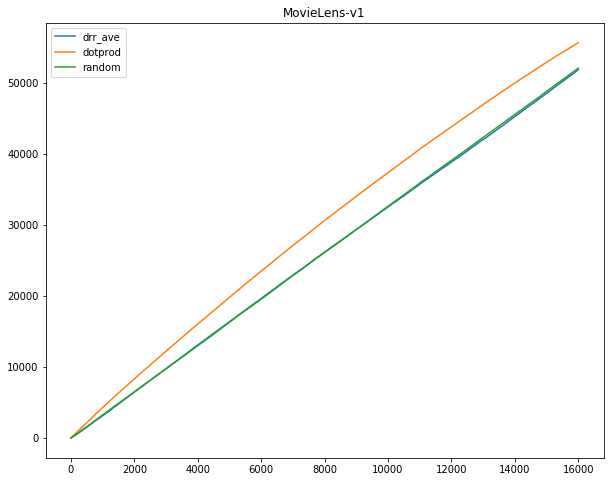

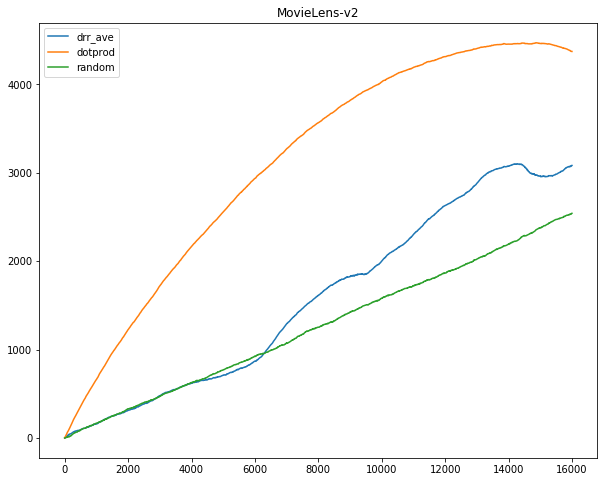

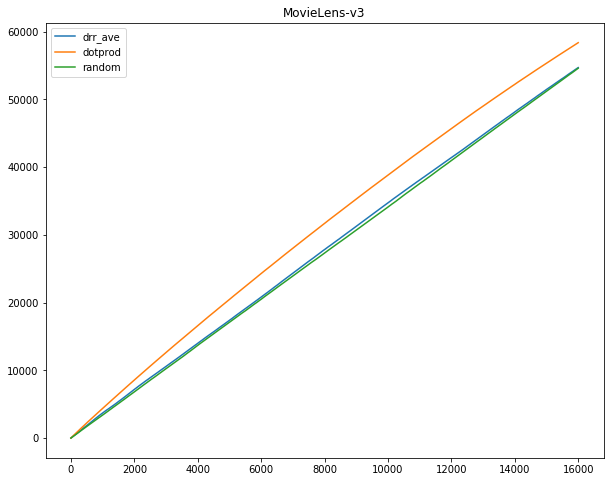

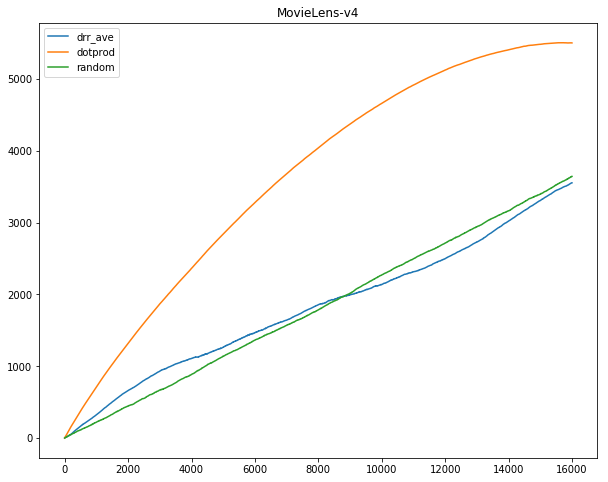

In [10]:
import matplotlib.pylab as plt
%matplotlib inline

for envid, res in results.items():
    
    plt.figure(figsize=(10, 8))
    
    for agent_name, interactions in res.items():
        rewards = []
        for i in interactions:
            rewards.extend(i.rewards)
        
        plt.plot(np.cumsum(rewards), label=agent_name)
    
    plt.legend()
    plt.title(envid)
    
#results['MovieLens-v1']['ddpg']